# Capstone: NLP Sentiment Analysis for Alpha Research

## 🎯 Project Overview

Build a sentiment-based trading signal system using:
1. Financial news sentiment analysis
2. Social media (synthetic) sentiment tracking
3. Combining sentiment with price data for predictions
4. Trading strategy based on sentiment indicators

In [1]:
# NLP Sentiment Alpha Research
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("="*70)
print("CAPSTONE: NLP SENTIMENT ALPHA RESEARCH")
print("="*70)

CAPSTONE: NLP SENTIMENT ALPHA RESEARCH


## Part 1: Financial Lexicon-Based Sentiment

In [2]:
# Financial Sentiment Lexicon
# Based on Loughran-McDonald Financial Sentiment Dictionary concepts

POSITIVE_WORDS = {
    'gain', 'gains', 'profit', 'profitable', 'growth', 'growing', 'surge',
    'surged', 'rally', 'rallied', 'bullish', 'outperform', 'beat', 'beats',
    'exceeded', 'strong', 'strength', 'upgrade', 'upgraded', 'positive',
    'opportunity', 'opportunities', 'optimistic', 'favorable', 'success',
    'successful', 'boost', 'boosted', 'improve', 'improved', 'improving'
}

NEGATIVE_WORDS = {
    'loss', 'losses', 'decline', 'declining', 'fall', 'falling', 'drop',
    'dropped', 'plunge', 'plunged', 'bearish', 'underperform', 'miss',
    'missed', 'weak', 'weakness', 'downgrade', 'downgraded', 'negative',
    'risk', 'risks', 'concern', 'concerns', 'worried', 'fear', 'fears',
    'disappointing', 'disappoints', 'failure', 'failed', 'struggling'
}

UNCERTAINTY_WORDS = {
    'uncertain', 'uncertainty', 'volatile', 'volatility', 'maybe',
    'possibly', 'could', 'might', 'unclear', 'unpredictable'
}

def calculate_sentiment(text):
    """Calculate sentiment scores from text."""
    words = text.lower().split()
    total_words = len(words)
    
    if total_words == 0:
        return {'positive': 0, 'negative': 0, 'uncertainty': 0, 'net_sentiment': 0}
    
    positive_count = sum(1 for w in words if w in POSITIVE_WORDS)
    negative_count = sum(1 for w in words if w in NEGATIVE_WORDS)
    uncertainty_count = sum(1 for w in words if w in UNCERTAINTY_WORDS)
    
    return {
        'positive': positive_count / total_words,
        'negative': negative_count / total_words,
        'uncertainty': uncertainty_count / total_words,
        'net_sentiment': (positive_count - negative_count) / total_words
    }

# Example headlines
headlines = [
    "Apple stock surges on strong iPhone sales beat expectations",
    "Microsoft shares rally after cloud growth exceeds forecasts",
    "Goldman Sachs reports profit decline amid trading weakness",
    "JPMorgan warns of uncertain economic outlook and risks",
    "Google faces concerns over advertising revenue growth"
]

print("\n" + "="*60)
print("LEXICON-BASED SENTIMENT ANALYSIS")
print("="*60)

for headline in headlines:
    sentiment = calculate_sentiment(headline)
    print(f"\nHeadline: {headline}")
    print(f"  Net Sentiment: {sentiment['net_sentiment']:.3f}")
    print(f"  Positive: {sentiment['positive']:.3f}, Negative: {sentiment['negative']:.3f}")


LEXICON-BASED SENTIMENT ANALYSIS

Headline: Apple stock surges on strong iPhone sales beat expectations
  Net Sentiment: 0.222
  Positive: 0.222, Negative: 0.000

Headline: Microsoft shares rally after cloud growth exceeds forecasts
  Net Sentiment: 0.250
  Positive: 0.250, Negative: 0.000

Headline: Goldman Sachs reports profit decline amid trading weakness
  Net Sentiment: -0.125
  Positive: 0.125, Negative: 0.250

Headline: JPMorgan warns of uncertain economic outlook and risks
  Net Sentiment: -0.125
  Positive: 0.000, Negative: 0.125

Headline: Google faces concerns over advertising revenue growth
  Net Sentiment: 0.000
  Positive: 0.143, Negative: 0.143


## Part 2: Generate Synthetic Sentiment Data

In [3]:
# Download price data and generate synthetic sentiment
print("\n" + "="*60)
print("DOWNLOADING PRICE DATA")
print("="*60)

STOCKS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=2*365)

prices = yf.download(STOCKS, start=start_date, end=end_date, progress=False, auto_adjust=True)['Close']
returns = prices.pct_change().dropna()

print(f"✅ Downloaded {len(returns)} days of price data")

# Generate synthetic sentiment (correlated with future returns + noise)
def generate_synthetic_sentiment(returns, predictive_power=0.1):
    """Generate synthetic sentiment data with some predictive power."""
    sentiment = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    for stock in returns.columns:
        # Base sentiment is related to past 5-day returns
        momentum = returns[stock].rolling(5).mean()
        
        # Add some forward-looking component (represents "smart money")
        future_return = returns[stock].shift(-1)
        
        # Combine with noise
        signal = (momentum * 0.5 + future_return * predictive_power).fillna(0)
        noise = np.random.normal(0, 0.02, len(signal))
        
        sentiment[stock] = np.clip(signal + noise, -1, 1)
    
    return sentiment

sentiment_data = generate_synthetic_sentiment(returns, predictive_power=0.15)

print("\n📊 Generated synthetic sentiment data")
print(sentiment_data.describe().round(3))


DOWNLOADING PRICE DATA
✅ Downloaded 500 days of price data

📊 Generated synthetic sentiment data
Ticker     AAPL    GOOGL       GS      JPM     MSFT
count   500.000  500.000  500.000  500.000  500.000
mean      0.001    0.002    0.004    0.002    0.000
std       0.020    0.020    0.020    0.020    0.020
min      -0.060   -0.056   -0.053   -0.058   -0.059
25%      -0.014   -0.012   -0.011   -0.011   -0.014
50%       0.001    0.001    0.003    0.001   -0.001
75%       0.014    0.015    0.017    0.015    0.014
max       0.081    0.061    0.057    0.068    0.066


## Part 3: Sentiment-Based Trading Signals

In [4]:
# Create sentiment-enhanced features
print("\n" + "="*60)
print("SENTIMENT-ENHANCED FEATURES")
print("="*60)

def create_sentiment_features(returns, sentiment, stock):
    """Create features combining price and sentiment data."""
    df = pd.DataFrame(index=returns.index)
    
    # Price features
    df['ret_1'] = returns[stock].shift(1)
    df['ret_5'] = returns[stock].rolling(5).mean().shift(1)
    df['volatility'] = returns[stock].rolling(20).std().shift(1)
    
    # Sentiment features
    df['sentiment'] = sentiment[stock].shift(1)
    df['sentiment_ma5'] = sentiment[stock].rolling(5).mean().shift(1)
    df['sentiment_change'] = sentiment[stock].diff().shift(1)
    
    # Interaction features
    df['sent_x_vol'] = df['sentiment'] * df['volatility']
    df['sent_x_mom'] = df['sentiment'] * df['ret_5']
    
    # Target
    df['target'] = (returns[stock].shift(-1) > 0).astype(int)
    
    return df.dropna()

# Train models for each stock
from sklearn.metrics import accuracy_score, classification_report

results = {}

for stock in STOCKS:
    df = create_sentiment_features(returns, sentiment_data, stock)
    
    feature_cols = [c for c in df.columns if c != 'target']
    X = df[feature_cols]
    y = df['target']
    
    # Time series split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Feature importance
    importance = dict(zip(feature_cols, model.feature_importances_))
    
    results[stock] = {
        'accuracy': accuracy,
        'sentiment_importance': importance.get('sentiment', 0) + importance.get('sentiment_ma5', 0)
    }
    
    print(f"\n{stock}:")
    print(f"  Accuracy: {accuracy:.2%}")
    print(f"  Top features: {sorted(importance.items(), key=lambda x: -x[1])[:3]}")


SENTIMENT-ENHANCED FEATURES

AAPL:
  Accuracy: 50.00%
  Top features: [('ret_1', np.float64(0.17193241327555628)), ('sentiment_change', np.float64(0.13698088658457624)), ('sent_x_mom', np.float64(0.13657398048375258))]

GOOGL:
  Accuracy: 53.12%
  Top features: [('sentiment_change', np.float64(0.1565613724929874)), ('volatility', np.float64(0.14698663322484404)), ('ret_5', np.float64(0.13862067057604907))]

MSFT:
  Accuracy: 54.17%
  Top features: [('sentiment_ma5', np.float64(0.14804464640216483)), ('ret_5', np.float64(0.1472240816507518)), ('volatility', np.float64(0.13511192168256692))]

GS:
  Accuracy: 54.17%
  Top features: [('volatility', np.float64(0.15563026382891532)), ('sentiment', np.float64(0.13391454018559124)), ('sent_x_mom', np.float64(0.12950470090676242))]

JPM:
  Accuracy: 52.08%
  Top features: [('ret_5', np.float64(0.1593149713280725)), ('volatility', np.float64(0.13608267210505637)), ('ret_1', np.float64(0.12945301627883463))]


## Part 4: Sentiment Trading Strategy Backtest


SENTIMENT STRATEGY BACKTEST

📊 Strategy Performance:
   Total Return: 2.49%
   Sharpe Ratio: 0.51
   Max Drawdown: -2.44%
   Buy & Hold Return: 77.19%


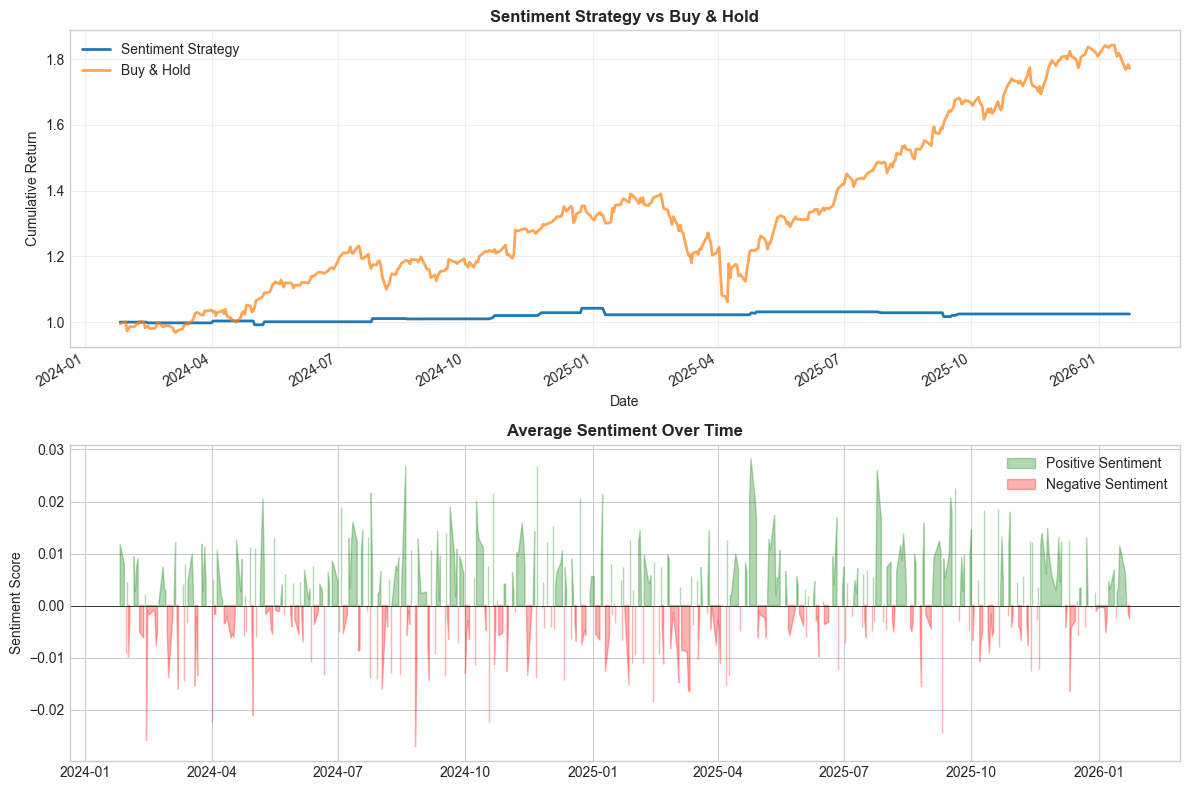

In [5]:
# Simple sentiment strategy backtest
print("\n" + "="*60)
print("SENTIMENT STRATEGY BACKTEST")
print("="*60)

def backtest_sentiment_strategy(returns, sentiment, threshold=0.02):
    """Backtest a simple sentiment-based strategy."""
    # Average sentiment across all stocks
    avg_sentiment = sentiment.mean(axis=1)
    
    # Generate signals
    signals = pd.Series(0, index=returns.index)
    signals[avg_sentiment.shift(1) > threshold] = 1   # Long when sentiment positive
    signals[avg_sentiment.shift(1) < -threshold] = -1  # Short when sentiment negative
    
    # Calculate portfolio returns
    avg_returns = returns.mean(axis=1)
    strategy_returns = signals * avg_returns
    
    # Performance metrics
    total_return = (1 + strategy_returns).cumprod().iloc[-1] - 1
    sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
    max_dd = ((1 + strategy_returns).cumprod() / (1 + strategy_returns).cumprod().cummax() - 1).min()
    
    return {
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'strategy_returns': strategy_returns,
        'signals': signals
    }

# Run backtest
results = backtest_sentiment_strategy(returns, sentiment_data)

print(f"\n📊 Strategy Performance:")
print(f"   Total Return: {results['total_return']:.2%}")
print(f"   Sharpe Ratio: {results['sharpe']:.2f}")
print(f"   Max Drawdown: {results['max_drawdown']:.2%}")

# Compare to buy and hold
bh_return = (1 + returns.mean(axis=1)).cumprod().iloc[-1] - 1
print(f"   Buy & Hold Return: {bh_return:.2%}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Cumulative returns
ax1 = axes[0]
strategy_cum = (1 + results['strategy_returns']).cumprod()
bh_cum = (1 + returns.mean(axis=1)).cumprod()
strategy_cum.plot(ax=ax1, label='Sentiment Strategy', linewidth=2)
bh_cum.plot(ax=ax1, label='Buy & Hold', linewidth=2, alpha=0.7)
ax1.set_title('Sentiment Strategy vs Buy & Hold', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sentiment and signals
ax2 = axes[1]
sentiment_avg = sentiment_data.mean(axis=1)
ax2.fill_between(sentiment_avg.index, sentiment_avg.values, 0, 
                 where=sentiment_avg > 0, alpha=0.3, color='green', label='Positive Sentiment')
ax2.fill_between(sentiment_avg.index, sentiment_avg.values, 0, 
                 where=sentiment_avg < 0, alpha=0.3, color='red', label='Negative Sentiment')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_title('Average Sentiment Over Time', fontweight='bold')
ax2.set_ylabel('Sentiment Score')
ax2.legend()

plt.tight_layout()
plt.show()

## Part 5: TF-IDF Feature Extraction Demo

In [6]:
# TF-IDF Feature Extraction
print("\n" + "="*60)
print("TF-IDF FEATURE EXTRACTION")
print("="*60)

# Sample financial headlines
sample_texts = [
    "Apple reports record iPhone sales growth in Asia",
    "Microsoft Azure cloud revenue beats analyst expectations",
    "Goldman trading desk losses widen amid market volatility",
    "JPMorgan CEO warns of economic risks and inflation concerns",
    "Google advertising revenue growth slows unexpectedly",
    "Apple stock surges on strong quarterly earnings beat",
    "Tech stocks rally as Fed signals rate pause",
    "Bank stocks decline on regulatory concerns"
]

# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_texts)

print(f"\nVocabulary size: {len(vectorizer.vocabulary_)}")
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Show top words by average TF-IDF
feature_names = vectorizer.get_feature_names_out()
avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
top_words = sorted(zip(feature_names, avg_tfidf), key=lambda x: -x[1])[:10]

print(f"\nTop TF-IDF words:")
for word, score in top_words:
    print(f"  {word}: {score:.4f}")


TF-IDF FEATURE EXTRACTION

Vocabulary size: 49
TF-IDF matrix shape: (8, 49)

Top TF-IDF words:
  concerns: 0.0904
  stocks: 0.0904
  growth: 0.0865
  revenue: 0.0855
  apple: 0.0819
  bank: 0.0596
  decline: 0.0596
  regulatory: 0.0596
  advertising: 0.0538
  google: 0.0538


## 🎯 Key Takeaways

1. **Lexicon-Based**: Domain-specific dictionaries (Loughran-McDonald) outperform general sentiment
2. **Timing**: Sentiment leads price movements, giving predictive edge
3. **Combination**: Best signals combine sentiment with price/volume data
4. **TF-IDF**: Useful for converting text to numerical features
5. **Alpha Decay**: Sentiment signals decay quickly - need real-time processing